This example is to show how to make use of the Xception neural network and train the output layer. Additionally, once we train the output layer, we will fine-tune the entire network by training all weights using by applying a low learning rate.

We will make use of the The Kaggle Cats vs. Dogs Dataset.
We will train a neural network to recognize cats and dogs for this example.

The dogs and cats dataset is relatively large and will not easily fit into a system with less than 12GB, such as Colab. Because of this side, special handling is required. Rather than loading the dataset as a Numpy array, as done previously in this course, we will load it as a prefetched dataset so that only the portions of the dataset currently needed are in RAM. If you wish to load the dataset, in its entirety, as a Numpy array, add the batch_size=-1 option to the load command below.


In [14]:
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

train_ds, validation_ds = tfds.load(
    "cats_vs_dogs",
    split=["train[:40%]", "train[40%:50%]"],
    as_supervised=True,  # Include labels
)

num_train = tf.data.experimental.cardinality(train_ds)
num_test = tf.data.experimental.cardinality(validation_ds)

print(f"Number of training samples: {num_train}")
print(f"Number of validation samples: {num_test}")

Number of training samples: 9305
Number of validation samples: 2326


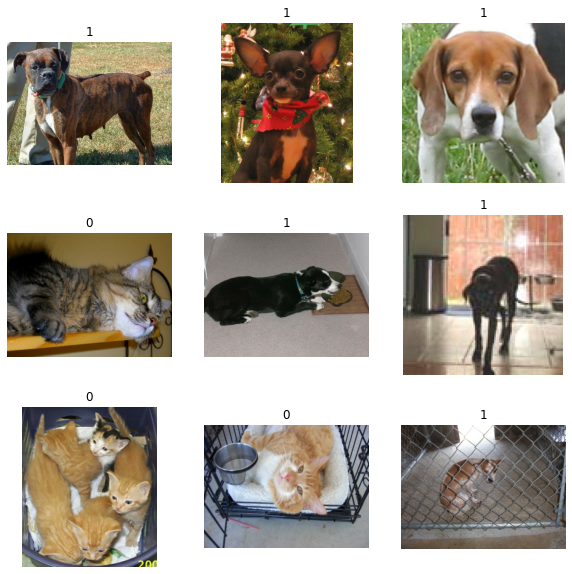

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

Upon examining the above images, another problem becomes evident. The images are of various sizes. We will standardize all images to 150x150 with the following code.

In [16]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [17]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache() \
    .batch(batch_size).prefetch(buffer_size=10)

In [19]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [20]:
# augmentation
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

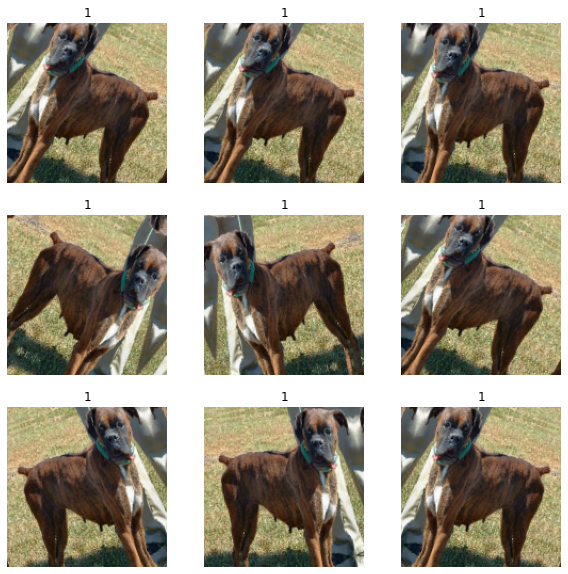

In [21]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

# Create a Network and Transfer Weights

We are now ready to create our new neural network with transferred weights. We will transfer the weights from an Xception neural network that contains weights trained for imagenet. 

The base Xception neural network accepts an image of 299x299. However, we would like to use 150x150. It turns out that it is relatively easy to overcome this difference. Convolutional neural networks move a kernel across an image tensor as they scan. The number of weights is defined by the size of the layer's kernel, not the image that the kernel scans. As a result, we can discard the old input layer and recreate an input layer consistent with our desired image size. We specify include_top as false and specify our input shape.

Create a Network and Transfer Weights
We are now ready to create our new neural network with transferred weights. We will transfer the weights from an Xception neural network that contains weights trained for imagenet. We load the existing Xception neural network with keras.applications. There is quite a bit going on with the loading of the base_model, so we will examine this call piece by piece.

The base Xception neural network accepts an image of 299x299. However, we would like to use 150x150. It turns out that it is relatively easy to overcome this difference. Convolutional neural networks move a kernel across an image tensor as they scan. The number of weights is defined by the size of the layer's kernel, not the image that the kernel scans. As a result, we can discard the old input layer and recreate an input layer consistent with our desired image size. We specify include_top as false and specify our input shape.

We freeze the base model so that the model will not update existing weights as training occurs. We create the new input layer that consists of 150x150 by 3 RGB color components. These RGB components are integer numbers between 0 and 255. Neural networks deal better with floating-point numbers that are distributed around zero. To accomplish this neural network advantage, we normalize each RGB component to between -1 and 1.

The batch normalization layers do require special consideration. We need to keep these layers in inference mode when we unfreeze the base model for fine-tuning. To do this, we make sure that the base model is running in inference mode here.

In [22]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)   #127.5 is 255/2, offset = -1 is to make it between -1 and 1
x = scale_layer(x)

# The base model contains batchnorm layers. 
# We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, 
# so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0      

In [24]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True), 
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 2
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/2
291/291 [==============================] - 949s 3s/step - loss: 0.1083 - binary_accuracy: 0.9559 - val_loss: 0.0708 - val_binary_accuracy: 0.9716
Epoch 2/2
291/291 [==============================] - 925s 3s/step - loss: 0.1022 - binary_accuracy: 0.9578 - val_loss: 0.0705 - val_binary_accuracy: 0.9716


#  Finetune the Model
Finally, we will finetune the model. First, we set all weights to trainable and then train the neural network with a low learning rate (1e-5). This fine tuning results in an accuracy in the upper 90% range. The fine tuning allows all weights in the neural network to recieve slight adjustment to optimize for the dogs/cats data.

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed training=False(this is a parameter in base_model) when calling it.
# This means that the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 2
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             